# TO DO:
1. Wrap up one function for feature generation 
2. Wrap up one function for model training 
3. Within the submission API, consider proper concat of cache and new test 
    
    * V1 features are row-based --> don't need cache. 
    * V2 features are based on sec_in_bucket (cross-section feat) --> don't need cache. (Perhaps the gen_v2_features function should be changed to not using groupby() ? )
    * V3 features requires timeseries data -->  the cache is needed.
    * The cache should save the timeseries records of all stocks with sufficient length. 
    * The row after concat should be re-ordered. 
    * After calculate features, only the current seconds_in_bucket should be returned. 
    * Standarization: in the training phase, the standarization is implemented on a multi-day scale. In the cached dataset, only limited timesteps are used in Standarization. 
    * Standarization: during training, perhaps we should perform Standarization on cross-section only. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from itertools import combinations
import seaborn as sns
import os, sys, warnings
from time import time 
from create_feature import *

import lightgbm as lgb
import joblib, gc
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from glob import glob

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
def gen_less_features(df_train, feature_dicts):
    
    df_train.fillna(0, inplace=True)
    df_train = reduce_mem_usage(df_train, verbose=0)

    df_v1, v1_feat, v1_feat_cat = gen_v1_features(df_train, feature_dicts['prices'])
    feature_dicts['v1_features'] = v1_feat
    feature_dicts['v1_feature_category'] = v1_feat_cat
    
    v2_feat_cols = feature_dicts['prices'] + feature_dicts['sizes'] + feature_dicts['v1_features']
    df_v2, v2_features = gen_v2_features(df_v1, v2_feat_cols)
    feature_dicts['v2_features'] = v2_features
    
    # df_v3, v3_features = gen_v3_features(
    #     df_v2, 
    #     feature_dicts['prices'],
    #     feature_dicts['sizes'],
    #     feature_dicts['v1_features']
    #     )
    
    # feature_dicts['v3_features'] = v3_features
    
    df_v2.fillna(0, inplace=True)
    df_v2.replace([np.inf, -np.inf], 0, inplace=True)
    df_v2 = reduce_mem_usage(df_v2, verbose=0)
    
    return df_v2, feature_dicts

In [3]:
def prepare_data(csv_file, feature_dicts, nrows=None, save_csv=None):
    
    df = pd.read_csv(csv_file, nrows=nrows)
    df = df[~df['target'].isnull()] 
    df.reset_index(drop=True, inplace=True)

    print(df.shape)
    print(f"Trading days: {df['date_id'].nunique()}")
    print(f"Stocks: {df['stock_id'].nunique()}")

    df_final, feature_dicts = gen_less_features(df, feature_dicts)
    
    if save_csv:
        df_final.to_csv(save_csv, index=False)
    
    return df_final, feature_dicts

In [11]:
def train_and_cross_validate(df, feature_cols, category_cols, lgb_params, model_name, save_dir, scaler_file=None, n_splits=5):
    
    scale_cols = [x for x in feature_cols if x not in category_cols]
    scaler = StandardScaler().fit(df[scale_cols])
    
    if scaler_file:
        joblib.dump(scaler, scaler_file)

    df[scale_cols] = scaler.transform(df[scale_cols])
    # df_valid[scale_cols] = scaler.transform(df_valid[scale_cols])
    
    check_invalids = pd.DataFrame(columns=['null', 'inf'])
    for col in df.columns:
        try:
            check_invalids.loc[col] = [df[col].isnull().sum(), np.isinf(df[col]).sum()]
        except:
            print("Skip column: ", col)
            pass
        
    has_invalids = check_invalids.T[check_invalids.sum(axis=0)!=0]
    
    if len(has_invalids) > 0:
        print("Invalid values were found in dataframe.")
        print(has_invalids)
        raise Exception("Invalid values in dataframe")
    
    k_fold = KFold(n_splits=n_splits, shuffle=False, random_state=None)
    kf_split = k_fold.split(df['date_id'].unique())
    
    mae_scores = []
    models = []
    
    print("Start Cross-validation...")
    for fold, (train_dates, valid_dates) in enumerate(kf_split):
        
        print(f"Fold {fold+1}")
        fold_start = time()
        
        # split train and valid set
        df_train_fold = df[df["date_id"].isin(train_dates)]
        half_valid = int(len(valid_dates)/2)
        df_valid_fold_1 = df[df["date_id"].isin(valid_dates[:half_valid])]
        df_valid_fold_2 = df[df["date_id"].isin(valid_dates[half_valid:])]
        
        print(f"Train  : {df_train_fold[feature_cols].shape}")
        print(f"Valid 1: {df_valid_fold_1[feature_cols].shape}")
        print(f"Valid 2: {df_valid_fold_2[feature_cols].shape}")
        
        print(f"Data preparation finished. Start training...")
        
        training_start = time()
        
        lgb_model = lgb.LGBMRegressor(**lgb_params)
        
        lgb_model.fit(
            df_train_fold[feature_cols], 
            df_train_fold['target'],
            eval_set=[(df_valid_fold_1[feature_cols], df_valid_fold_1['target'])],
            feature_name = feature_cols,
            categorical_feature = category_cols,
            callbacks=[lgb.callback.log_evaluation(period=100)],
            )
        
        models.append(lgb_model)
        
        model_file = f"{save_dir}/{model_name}_fold_{fold+1}.pkl" 
        joblib.dump(lgb_model, model_file)
        
        print(f"Fold {fold+1} Trainning finished. Time elapsed: {time()-training_start:.2f}s")
        
        y_pred_valid = lgb_model.predict(df_valid_fold_2[feature_cols])
        mae = mean_absolute_error(df_valid_fold_2['target'].values, y_pred_valid)
        mae_scores.append(mae)

        print(f"Fold {fold+1} MAE: {mae}")
        print(f"Fold {fold+1} Time elapsed: {time()-fold_start:.2f}s")
        
        del df_train_fold, df_valid_fold_1, df_valid_fold_2, y_pred_valid
        gc.collect()
        
    return models, mae_scores

In [5]:
feature_dicts = {
    'prices': ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"],
    'sizes':  ["matched_size", "bid_size", "ask_size", "imbalance_size"],
    "category": ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag']
    }

df, feature_dicts = prepare_data("../data/train.csv", feature_dicts, nrows=None, save_csv=None)

feature_cols, category_cols = gen_feature_cols(feature_dicts)

print(len(feature_cols))
print(len(category_cols))

(5237892, 17)
Trading days: 481
Stocks: 200
267
8


In [12]:
# set lgb parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.015, #0.009,#0.018,
    'max_depth': 12,#9,
    'n_estimators': 800,#600,
    'num_leaves': 1024,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 24,
    'importance_type': 'gain',
    'verbose': -1,
    }

imp_cv_results = train_and_cross_validate(
    df,
    feature_cols, 
    category_cols, 
    lgb_params, 
    model_name = "lgb_v1v2", 
    save_dir = "../data", 
    scaler_file="../data/lgb_v1v2_scaler.pkl", 
    n_splits=5)

Skip column:  row_id
Start Cross-validation...
Fold 1
Train  : (4203153, 267)
Valid 1: (507839, 267)
Valid 2: (526900, 267)
Data preparation finished. Start training...
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[100]	valid_0's l1: 5.21622
[200]	valid_0's l1: 5.20527
[300]	valid_0's l1: 5.20232
Fold 1 Trainning finished. Time elapsed: 261.23s
Fold 1 MAE: 6.186818810072384
Fold 1 Time elapsed: 269.35s
Fold 2
Train  : (4197017, 267)
Valid 1: (520025, 267)
Valid 2: (520850, 267)
Data preparation finished. Start training...
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[100]	valid_0's l1: 7.18887
[200]	valid_0's l1: 7.1607
[300]	valid_0's l1: 7.1497
[400]	valid_0's l1: 7.1443
[500]	valid_0's l1: 7.14
[600]	valid_0's l1: 7.13743
[700]	valid_0's l1: 7.13609
[800]	valid_0's l1: 7.13505
Fold 2 Trainning finished. Time elapsed: 465.25s
Fold 2 MAE: 6.82552584803175
Fold 2 Time elapsed: 477.01s
Fold 3
Train  : 

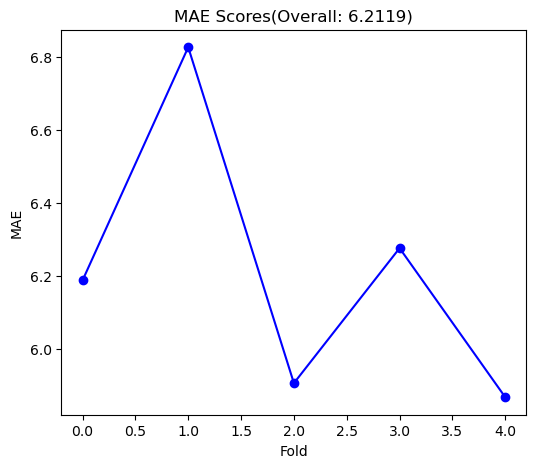

In [14]:
# plot mae scores
plt.figure(figsize=(6, 5))

mae_scores = imp_cv_results[1]

plt.plot(mae_scores, marker='o', color='blue', label='MAE')
plt.title(f'MAE Scores(Overall: {np.mean(mae_scores):.4f})')
plt.xlabel('Fold')
plt.ylabel('MAE')

plt.show()

In [ ]:
# A simple validation split: keep the last 45 days for validation
split_day = 435
df_train = df[df["date_id"] <= split_day]
df_valid = df[df["date_id"] > split_day]
print(f"Train : {df_train.shape}, Valid : {df_valid.shape}")

In [ ]:
# set lgb parameters
lgb_params = {
    'learning_rate': 0.009,#0.018,
    'max_depth': 10,#9,
    'n_estimators': 700,#600,
    'num_leaves': 500,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 24,
    'importance_type': 'gain',
    'verbose': -1,
    }

# cv_results = train_and_cross_validate(
#     df_train,
#     df_valid,
#     feature_cols, 
#     category_cols, 
#     lgb_params, 
#     model_name = "lgb_cv", 
#     save_dir = "../data", 
#     scaler_file="../data/lgb_cv_scaler.pkl", 
#     n_splits=5)

In [ ]:
def calc_feature_importance(model_name, model_dir, feature_cols):
    
    model_files = glob(f"{model_dir}/{model_name}_fold_*.pkl")
    models = [joblib.load(model_file) for model_file in model_files]

    df_importance = []
    
    for model in models:
        feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_cols})
        feature_imp.sort_values(by='Value', ascending=False, inplace=True)
        df_importance.append(feature_imp)
        
    df_importance = pd.concat(df_importance)
    df_importance = df_importance.groupby('Feature').mean().reset_index()

    df_importance.sort_values(by='Value', ascending=False, inplace=True)
    df_importance = df_importance.reset_index(drop=True)
    
    return df_importance

In [ ]:
df_importance = calc_feature_importance('lgb_cv', '../data',  feature_cols)

percentile=20
imp_thred = np.percentile(df_importance['Value'].values, percentile)
less_important = df_importance[df_importance['Value'] < imp_thred]

print(f"Importance Threshold ({percentile} percentile): {imp_thred}")
print(f"Number of less important features: {len(less_important)}")

fig, axes = plt.subplots(1, 3, figsize=(18, 11))

less_imp_v1 = less_important[less_important['Feature'].isin(feature_dicts['v1_features']+feature_dicts['v1_feature_category'])]
less_imp_v2 = less_important[less_important['Feature'].isin(feature_dicts['v2_features'])]
less_imp_v3 = less_important[less_important['Feature'].isin(feature_dicts['v3_features'])]

for i, (ax, df_lss) in enumerate(zip(axes, [less_imp_v1, less_imp_v2, less_imp_v3])):
    sns.barplot(x="Value", y="Feature", data=df_lss, ax=ax)
    ax.grid()
    ax.set_title(f"V{i+1} Features")
# ax.set_xlim(0, 2000)
plt.tight_layout()
plt.show()

# Reduce less important features

In [ ]:
[x for x in less_imp_v3['Feature'].values if 'std_' in x ]

In [ ]:
[x for x in less_imp_v3['Feature'].values if 'mean_' in x ]

In [ ]:
[x for x in less_imp_v3['Feature'].values if 'max_' in x ]

In [ ]:
[x for x in less_imp_v3['Feature'].values if 'min_' in x ]

In [ ]:
[x for x in less_imp_v3['Feature'].values if 'pct_' in x ]

In [ ]:
imp_feature_cols = [col for col in feature_cols if col not in less_important['Feature'].values]
imp_category_cols = [col for col in category_cols if col not in less_important['Feature'].values]

print(len(imp_feature_cols))
print(len(imp_category_cols))

# set lgb parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.015, #0.009,#0.018,
    'max_depth': 12,#9,
    'n_estimators': 800,#600,
    'num_leaves': 1024,#440,
    'objective': 'mae',
    'random_state': 42,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'early_stopping_rounds': 50,
    'num_threads': 24,
    'importance_type': 'gain',
    'verbose': -1,
    }

imp_cv_results = train_and_cross_validate(
    df_train,
    df_valid,
    imp_feature_cols, 
    imp_category_cols, 
    lgb_params, 
    model_name = "lgb_cv_imp_40", 
    save_dir = "../data", 
    scaler_file="../data/lgb_cv_imp_40_scaler.pkl", 
    n_splits=5)

In [ ]:
# plot mae scores
plt.figure(figsize=(6, 5))

mae_scores = imp_cv_results[1]

plt.plot(mae_scores, marker='o', color='blue', label='MAE')
plt.title(f'MAE Scores(Overall: {np.mean(mae_scores):.4f})')
plt.xlabel('Fold')
plt.ylabel('MAE')

plt.show()
    

In [ ]:
df_importance = calc_feature_importance('lgb_cv_imp', '../data',  imp_feature_cols)

fig, axes = plt.subplots(1, 3, figsize=(18, 11))

imp_v1 = df_importance[df_importance['Feature'].isin(feature_dicts['v1_features']+feature_dicts['v1_feature_category'])]
imp_v2 = df_importance[df_importance['Feature'].isin(feature_dicts['v2_features'])]
imp_v3 = df_importance[df_importance['Feature'].isin(feature_dicts['v3_features'])]

for i, (ax, df_lss) in enumerate(zip(axes, [imp_v1, imp_v2, imp_v3]])):
    sns.barplot(x="Value", y="Feature", data=df_lss, ax=ax)
    ax.grid()
    ax.set_title(f"V{i+1} Features")
# ax.set_xlim(0, 2000)
plt.tight_layout()
plt.show()
